In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# for multiple hypothesis correction
import statsmodels.stats.multitest as smt 

# For editable text. 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 15}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)


import cfrna_methods as toolkit

# for housekeeping gene validation
from scipy.stats import ttest_ind


# for PCA plots
from sklearn.decomposition import PCA

import os

/Users/sevahn/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300,
                bbox_inches = 'tight', transparent = True)

In [3]:
biofluid_pal = {}

biofluid_pal = {}
biofluid_pal['sediment'] = "#97D9E1"
biofluid_pal['supt'] = "#3F9ED9"
biofluid_pal['plasma'] = "#1F5B9E"
biofluid_pal['normal'] = "#0077be"
biofluid_pal['stone'] = "#34B7D3" # "#F9D71C"
biofluid_pal['bioivt'] = '#5fa8d3'

colors = ['#0d3b66', '#5fa8d3',  '#ee964b','#f4d35e', '#f95738','#D90368']

biofluid_pal[75] = colors[0]
biofluid_pal[150] = colors[1]

cols = [ "#0077be",  "#97D9E1",  "#ffd000",  "#3F9ED9" ] # "#1E9E9E",
for i, val in enumerate(['normal_sediment', 'normal_supt',
                         'stone_sediment', 'stone_supt']):
    print(val)
    sns.color_palette([cols[i]])
    plt.show()
    biofluid_pal[val] = cols[i]

normal_sediment
normal_supt
stone_sediment
stone_supt


# read in urine/plasma data

In [4]:
all_urine_raw = pd.read_csv("../data/rna_seq_cts/urine_htseq_cts.csv",
                       index_col = (0,1))

urine_qc = pd.read_csv("../data/rna_seq_cts/urine_qc_passing.csv",
                       index_col = 0, sep = ",")

In [5]:
passing_samples = urine_qc[urine_qc.failed_qc == "pass"].index.tolist()

In [6]:
plasma_raw = pd.read_csv('../data/ad_allcts_postQC_htseq_merged_unstranded_20221127.csv',
                        index_col = (0, 1))

urine_raw = all_urine_raw[passing_samples]

ad_meta = 'allAD_metadata_FINAL.csv'
ad_meta = pd.read_csv(f'../data/{ad_meta}', index_col = 0)

nci = ad_meta[ad_meta['Disease'] == 'NCI']
bioivt_id = nci[nci['Center'] == 'BioIVT'][['Run', 'Isolate', 'Gender']]

In [7]:
plasma_raw = plasma_raw.loc[:, plasma_raw.columns.isin(bioivt_id['Run'])]

good_genes = plasma_raw.index[:-6]
good_genes = [i for i in good_genes if 'ERCC' not in i[0]]

all_raw = plasma_raw.join(urine_raw)

`plasma_raw` is a df of raw counts with no duplicate column names since samples surviving QC did not have technical replicates.

In [8]:
all_raw_med_depth = np.median(all_raw.sum()) 
urine_raw_med_depth = np.median(urine_raw.sum())

In [9]:
cpm_plasma = toolkit.cpm(plasma_raw)
urine_cpm = toolkit.cpm(urine_raw)

logcpm_plasma = toolkit.logcpm_normalize(plasma_raw)
logcpm_urine = toolkit.logcpm_normalize(urine_raw)

# merge the two respective tables values then filter
all_cpm = cpm_plasma.join(urine_cpm)
all_logcpm = logcpm_plasma.join(logcpm_urine)


counts table has been cpm normalized
counts table has been cpm normalized
counts table has been logcpm normalized
counts table has been logcpm normalized


In [10]:
plasma_id = [i for i in all_logcpm if 'SRR' in i]
sed_id = [i for i in all_logcpm if 'sed' in i]
supt_id = [i for i in all_logcpm if 'supt' in i]
print('plasma: ', len(plasma_id))
print('sediment: ', len(sed_id))
print('supt: ', len(supt_id))

plasma:  18
sediment:  17
supt:  13


In [11]:
cpm_passing = toolkit.filter_cpm_aboveKThresh(all_cpm,
                                              cpm_thresh = 1.65, # ~8 cts/sample
                                              k_thresh = 13 / all_logcpm.shape[1])


cpm_urineonly = toolkit.filter_cpm_aboveKThresh(urine_cpm,
                                                cpm_thresh = 1.25,  # ~8 cts/sample
                                               k_thresh = 13 / logcpm_urine.shape[1])


19.9 % genes in at least 27.1 % samples above  1.65  CPM passed.
15.7 % genes in at least 43.3 % samples above  1.25  CPM passed.


In [12]:
# subset the raw counts
raw_cts_passing_QC = all_raw.loc(axis = 0)[:, cpm_passing.index.get_level_values(1)]
raw_cts_passingQC_urineOnly = urine_raw.loc(axis = 0)[:, cpm_urineonly.index.get_level_values(1)]

In [13]:
all_good_genes = [i for i in raw_cts_passing_QC.index.get_level_values(0) if 'ERCC' not in i]
urine_good_genes = [i for i in raw_cts_passingQC_urineOnly.index.get_level_values(0) if 'ERCC' not in i]

In [14]:
# drop the not-genes for 
urine_raw_pass_qc = raw_cts_passingQC_urineOnly.loc(axis = 0)[urine_good_genes, :]
urine_raw_pass_qc = urine_raw_pass_qc.iloc[:-6, :]

all_raw_pass_qc = raw_cts_passing_QC.loc(axis = 0)[all_good_genes, :]
all_raw_pass_qc = all_raw_pass_qc.iloc[:-6, :]

In [15]:
"""
fstart = 20231228
all_raw_pass_qc.to_csv(f'../data/{fstart}_filtered_sed_supt_bioivt.csv')
urine_raw_pass_qc.to_csv(f'../data/{fstart}_filtered_sed_supt_urineONLY.csv')"""

"\nfstart = 20231228\nall_raw_pass_qc.to_csv(f'../data/{fstart}_filtered_sed_supt_bioivt.csv')\nurine_raw_pass_qc.to_csv(f'../data/{fstart}_filtered_sed_supt_urineONLY.csv')"

# get the metadata

In [16]:
volumes = pd.read_excel("../data/pee_pilot_sample_attributes.xlsx", index_col  = 0,
                           sheet_name = "urine_volumes")
volumes.index = [str(i) if type(i) != str else i for i in volumes.index]


urine_creatinine = pd.read_excel("../data/pee_pilot_sample_attributes.xlsx",
           sheet_name = 'urine_creatinine', index_col = 0)
urine_creatinine.index = [str(i) for i in urine_creatinine.index]



### leukocyte data
leuks = pd.read_excel("../data/pee_pilot_sample_attributes.xlsx",
                       sheet_name = 'urine_dipstick', index_col = 0)
leuks = leuks.loc['leu'].to_frame()     
leuks.index = [str(i) if type(i) != str else i for i in leuks.index]

## patient metadata
params = pd.read_excel("../data/pee_pilot_sample_attributes.xlsx",
                                sheet_name = 'patient_metadata',
                       index_col = 1)

In [17]:
# all the normals were from men
urine_sex = params['Sex'].fillna('M').to_frame()
urine_sex.index = [str(i) if type(i) != str else i for i in urine_sex.index]

In [18]:
def get_meta(counts_df, meta_fname):
    patient_id = []
    sample_type = []
    stone_normal = []
    vol_samps = []
    creatinine_samps = []
    leuks_samps = []
    sex = []

    for i in counts_df.columns:    
        samp_components = i.split("_")
        patient = samp_components[0]
        
        

        if 'SRR' in i or 'plasma' in i:
            vol_samps += (ad_meta[ad_meta['Run'] == i]['Vol (ul)'].values / 1000).tolist()
            patient_id += ad_meta[ad_meta['Run'] == i]['Isolate'].values.tolist()
            creatinine_samps += [np.nan]
            sample_type += ['plasma']
            stone_normal += ['normal']
            leuks_samps += [0]
            sex += [bioivt_id[bioivt_id['Run'] == i].Gender.tolist()[0][0]]

        else:
            patient_id += [patient]
            sample_type += [samp_components[1]]
            if samp_components[0][0] == 'N':
                stone_normal += ['normal']
            else:
                stone_normal += ['stone']

            vol_info = volumes.loc[samp_components[0]]
            

            creatinine = urine_creatinine.loc[patient]['Adj for dilution (mg/dL)']
            creatinine_samps += [creatinine]
            
            if samp_components[1] == 'sediment':
                
                vol_samps += [vol_info['total volume for sediment']]

            elif samp_components[1] == 'supt':
                
                vol_samps += [vol_info['supt_vol_ml']]

        
            dipstick_value = leuks.loc[patient].values[0]
            if dipstick_value == '-':
                leuks_samps += [0]
            else:
                leuks_samps += [1]
            

            sex += urine_sex.loc[patient].to_list()
    
   
    # binarize sex like the leukocytes
    sex = [0 if i == 'F' else 1 for i in sex]
    
    
    
    meta = pd.DataFrame()
    meta['patient_id'] = patient_id
    meta['sample_type'] = sample_type
    meta['stone_normal'] = stone_normal
    meta['vol_samps'] = vol_samps
    meta['creatinine'] = creatinine_samps
    meta['leuks'] = leuks_samps
    meta['sex'] = sex
    #meta.to_csv(meta_fname, index = False, header = True)

    return(meta)

In [19]:
get_meta(raw_cts_passing_QC, '../data/20231225_bioivt_urine_meta.csv')

,patient_id,sample_type,stone_normal,vol_samps,creatinine,leuks,sex
0,17953,plasma,normal,0.906,NaN,0,1
1,17949,plasma,normal,1.000,NaN,0,1
2,17947,plasma,normal,1.000,NaN,0,0
3,17946,plasma,normal,1.000,NaN,0,1
4,17944,plasma,normal,0.892,NaN,0,0
5,17943,plasma,normal,1.000,NaN,0,0
6,17940,plasma,normal,1.000,NaN,0,1
7,17938,plasma,normal,1.000,NaN,0,0
8,17934,plasma,normal,1.000,NaN,0,0
9,17933,plasma,normal,1.000,NaN,0,1


In [20]:
get_meta(raw_cts_passingQC_urineOnly, '../data/20231226_urineONLY_meta.csv')

,patient_id,sample_type,stone_normal,vol_samps,creatinine,leuks,sex
0,1742,sediment,stone,17,100.66330,1,1
1,1749,sediment,stone,44,111.93920,1,1
2,1761,sediment,stone,28,62.03618,0,1
3,N2,sediment,normal,20,37.43141,0,1
4,1749,supt,stone,2,111.93920,1,1
5,1747,sediment,stone,36,84.20123,0,1
6,N3,supt,normal,8,68.94416,0,1
7,N1,sediment,normal,24,26.15554,0,1
8,1746,sediment,stone,16,142.84670,1,1
9,1741,sediment,stone,30,31.22978,1,0


# plot filtered genes and the distribution

In [21]:
def plot_cts(cts_data, hue_flag, f_save_name = False):
    pca = PCA(n_components = 2)
    reduced_sequencing_data = pca.fit_transform(cts_data.T)
    pcaRes = pd.DataFrame(data = reduced_sequencing_data)

    pcaRes.columns = ['PCA1', 'PCA2']
    pcaRes['biofluid'] = ['sediment' if 'sed' in i else 'supt' if 'supt' in i else 'plasma' for i in cts_data.columns]
    pcaRes['disease'] = ['normal' if i[0] == 'N' else 'stone' for i in cts_data.columns]
    pcaRes['sample_name'] = cts_data.columns
    pcaRes['disease_biofluid'] =  pcaRes.disease + "_" + pcaRes.biofluid    
   
    
    read_length = [75 if 'repool' in i else 150 for i in cts_data.columns]
    pcaRes['read_length'] = read_length
    
    plt.figure(figsize = (5, 5))

    sns.scatterplot(data = pcaRes,
                    x = 'PCA1', y = 'PCA2',
                   hue = hue_flag,
                    palette = biofluid_pal)
    
    pca1_var = np.round(pca.explained_variance_ratio_[0], 2) * 100
    pca2_var = np.round(pca.explained_variance_ratio_[1], 2) * 100
    
    plt.xlabel(f'PCA 1 {pca1_var}%')
    plt.ylabel(f'PCA 2 {pca2_var}%')
    
    plt.legend(bbox_to_anchor = (1.6, 0.5))
    
    
    #if f_save_name:  
    #    save_figure_pdf(plt, f_save_name)


In [22]:
all_hk = pd.read_excel("../data/HK_exons.xlsx",
                      index_col = 0)

all_hk_genes = np.unique(all_hk.index)

In [23]:
def plot_cts(cts_data, hue_flag, f_save_name = False):
    pca = PCA(n_components = 2)
    reduced_sequencing_data = pca.fit_transform(cts_data.T)
    pcaRes = pd.DataFrame(data = reduced_sequencing_data)

    pcaRes.columns = ['PCA1', 'PCA2']
    pcaRes['biofluid'] = ['sediment' if 'sed' in i else 'supt' if 'supt' in i else 'plasma' for i in cts_data.columns]
    pcaRes['disease'] = ['normal' if i[0] == 'N' else 'stone' for i in cts_data.columns]
    pcaRes['sample_name'] = cts_data.columns
    pcaRes['disease_biofluid'] =  pcaRes.disease + "_" + pcaRes.biofluid    
   
    
    read_length = [75 if 'repool' in i else 150 for i in cts_data.columns]
    pcaRes['read_length'] = read_length
    
    plt.figure(figsize = (5, 5))

    sns.scatterplot(data = pcaRes,
                    x = 'PCA1', y = 'PCA2',
                   hue = hue_flag,
                    palette = biofluid_pal)
    
    pca1_var = np.round(pca.explained_variance_ratio_[0], 2) * 100
    pca2_var = np.round(pca.explained_variance_ratio_[1], 2) * 100
    
    plt.xlabel(f'PCA 1 {pca1_var}%')
    plt.ylabel(f'PCA 2 {pca2_var}%')
    
    plt.legend(bbox_to_anchor = (1.6, 0.5))
    
    
    #if f_save_name:  
    #    save_figure_pdf(plt, f_save_name)


In [24]:
urine_only_cpmTMM = toolkit.logcpm_tmm("../data/20231228_filtered_sed_supt_urineONLY.csv",
                                      "../data/diffex/urine_only/20231228_urineOnly_TMM.csv")
urine_plasma_cpmTMM = toolkit.logcpm_tmm('../data/20231228_filtered_sed_supt_bioivt.csv',
                                 '../data/diffex/plasma_urine/20231228_urine_bioIVT_TMM.csv')

[ True]
[ True]


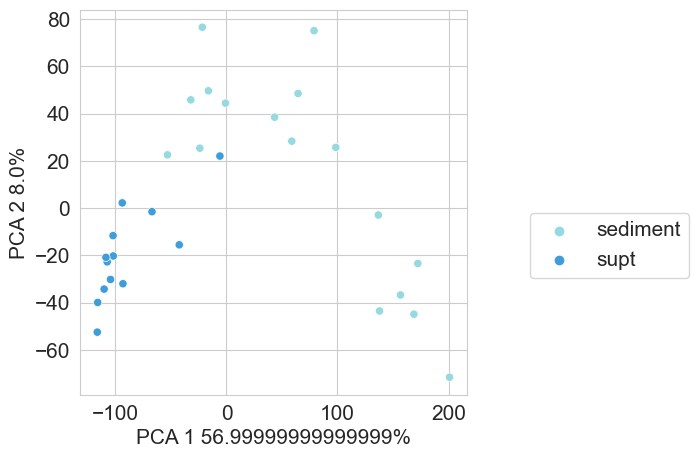

In [25]:
plot_cts(urine_only_cpmTMM, 'biofluid')
         #'../figures/20231230_sedSupt_urineOnly_cpmTMMFILTERED.pdf')

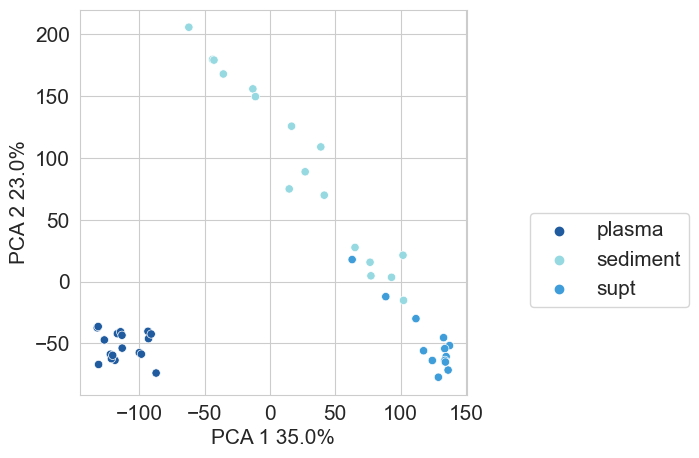

In [26]:
plot_cts(urine_plasma_cpmTMM, 'biofluid')
         #'../figures/20231230_sedSupt_bioivt_cpmTMMFILTERED.pdf')

In [27]:
def get_hk(df):
    
    # have it be ENSG first
    if 'ENSG' in df.index[0][0]:
        df  = df.swaplevel()

    sed_id = [i for i in df.columns if 'sed' in i]
    supt_id = [i for i in df.columns if 'supt' in i]
    

    urine_genes = [i[0] for i in df.index]

    lfc_sed_supt = []
    missing  = []
    present = []

    sed_vals = []
    supt_vals = []

    for gene in all_hk_genes:

        if gene not in urine_genes:
            missing += [gene]
            continue

        supt = df.loc[gene, supt_id].values.squeeze().tolist()
        sed = df.loc[gene, sed_id].values.squeeze().tolist()

        lfc_sed_supt += [np.median(sed) - np.median(supt)]

        sed_vals += [np.median(sed)]
        supt_vals += [np.median(supt)]
        

        present += [gene]


    sed_supt = ttest_ind(sed_vals, supt_vals)
    print('sed vs supt comparison ', sed_supt)
    return(sed_vals, supt_vals)

In [28]:
sed_vals, supt_vals = get_hk(urine_only_cpmTMM)

sed vs supt comparison  TtestResult(statistic=-0.26637236502415085, pvalue=0.7899576935559407, df=10466.0)
